# CD Spectroscopy Data Normalisation

A Jasco J-810 spectropolarimeter with a Peltier heating unit was used to obtain CD spectra between 200 and 300 nm. Samples were analysed at a volume of 200 µL in a 1 mm path-length cuvette. All oligos were analysed at 10 µM by using 20 µL of a 100 µM stock in the cuvette. 100 µL of 2X lithium cacodylate buffer stock was then added. Samples were either made up to 200 µL with ultrapure water (control), or were made up to 50 mM K+ and 8 µM NMM by adding 10 µL of 1 M potassium hydroxide and 1.6 µL of 1 mM NMM before making up to 200 µL with ultrapure water. The 2X stock of lithium cacodylate buffer was prepared by dissolving 550 mg cacodylic acid in 200 mL water and adjusting the pH to 6.0 using lithium hydroxide.

CD spectroscopy was conducted on the extension repeat oligo and its negative control, as well as oligos based on the PGQs in those genes which gave significant changes in 3’/5’ ratios upon addition of NMM

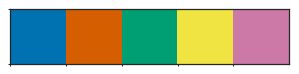

In [11]:
import glob
from math import factorial
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from Bio.SeqUtils import molecular_weight

%matplotlib inline
pd.options.display.max_rows = 100
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [5]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

From: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5334661/

To normalize the CD spectra of G-quadruplex use the formula $Δε(M^{−1}·cm^{−1}) =θ/(32980*c*l)$ where $θ$ is the CD ellipticity in millidegrees (mdeg), $c$ is the strand concentration in mol/L of G-quadruplex, and $l$ is the path length in cm.

Table 1
Values for the apparent molar extinction coefficient at 260 nm for a human telomeric G-quadruplex sequence determined by various methods. Values refer to strand concentration in a buffer containing 6 mM Na2HPO4, 2 mM NaH2PO4, 1 mM Na2EDTA, and 185 mM NaCl, pH 7.0, 20°C.

| Method                            | ε. M−1cm−1      | Comments                          |
|-----------------------------------|-----------------|-----------------------------------|
| Calculated, Nearest Neighbora     | 228,500         | Unfolded, single-strand form      |
| Colorimetric Phosphateb           | 196,480 ± 5,680 | Folded                            |
| Colorimetric Phosphate            | 200,310 ± 1,000 | Folded; independent determination |
| Absorbance, thermal denaturation  | 194,600         | Folded                            |
| Absorbance, enzymatic digestion   | 201,180         | Folded                            |
| Absorbance, alkaline denaturation | 199,700         | Folded                            |
| Average of all methods            | 198,450 ± 2,790 | Folded; %Hc = 15.1                |

a[1] R. Buscaglia, R. D. Gray and J. B. Chaires, Biopolymers 2013, 99, 1006–1018.
c%H is the per cent hyperchromism at 260 nm

In [88]:
all_spectra = []
for f in glob.glob('*.txt'):
    n = f.split('.')[0]
    seq, _, k = n.rsplit('_', 2)
    cd = pd.read_table(f, sep='\t', 
                       names=['Wavelength', 'cd', 'x', 'cntrl'],
                       usecols=['Wavelength', 'cd', 'cntrl'])
    cd['baseline_subtracted'] = df[n]['cd'] - df[n]['cntrl']
    cd['Normalised'] = savitzky_golay(
        (df[n]['baseline_subtracted'] / (32980 * 0.00001 * 0.1)).values,
        window_size=25,
        order=3
    )
    cd['Sequence'] = seq
    cd['Potassium'] = k
    cd = cd[['Sequence', 'Potassium', 'Wavelength', 'Normalised']].copy()
    all_spectra.append(cd)
all_spectra = pd.concat(all_spectra)
all_spectra['Sequence'] = all_spectra.Sequence.map({
    'mut_ext': 'Mutated Extensin Repeat',
    'ext': 'Extensin Repeat',
})
all_spectra['Potassium'] = all_spectra.Potassium.map({
    'pos': '+', 'neg': '-'
})
all_spectra.head()

,Sequence,Potassium,Wavelength,Normalised
0,Mutated Extensin Repeat,-,220,6.250834
1,Mutated Extensin Repeat,-,221,6.243666
2,Mutated Extensin Repeat,-,222,6.112260
3,Mutated Extensin Repeat,-,223,6.047957
4,Mutated Extensin Repeat,-,224,5.924907


/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


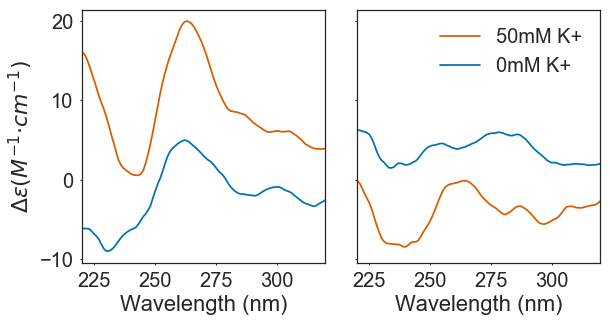

In [93]:
fig, axes = plt.subplots(figsize=(9, 5), ncols=2, sharex=True, sharey=True)
axes = axes.squeeze()
all_spectra['unit'] = 0
for ax, (n, group) in zip(axes.ravel(), all_spectra.groupby('Sequence')):
    sns.tsplot(group, time='Wavelength', value='Normalised', condition='Potassium', unit='unit', ax=ax, legend=False)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('')
axes[0].set_ylabel('$Δε(M^{−1}·cm^{−1})$')
axes[1].plot([], [], color=pal[1], label='50mM K+')
axes[1].plot([], [], color=pal[0], label='0mM K+')
axes[1].legend()
plt.tight_layout()
plt.savefig('cd_spec_ext_repeat.svg')
plt.show()